In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def conv_block(inputs, num_filter):
    x = layers.Conv2D(num_filter, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filter, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [3]:
def encoder_block(inputs,num_filter):
    x = conv_block(inputs, num_filter)
    p = layers.MaxPool2D((2, 2))(x)
    return x,p

In [4]:
def decoder_block(inputs, skip, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = layers.concatenate([x, skip])
    x = conv_block(x, num_filters)
    return x

In [5]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")

    return model

In [6]:
input_shape = (256, 256, 1)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
precision = tf.keras.metrics.Precision(
    thresholds=0.5)
recall = tf.keras.metrics.Recall(
    thresholds=0.5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[precision,recall])

data

In [8]:
# datasets for tf
from data_preprocessing import get_dataset_large

batch_size = 4
dataset = get_dataset_large("data/LITS_TFrecords_2D_Lesions/train/"
)
dataset = dataset.shuffle(5000,reshuffle_each_iteration=True).batch(batch_size)
valid_dataset = get_dataset_large("data/LITS_TFrecords_2D_Lesions/valid/"
)
valid_dataset = valid_dataset.batch(
    batch_size
)  # .shuffle(1000,  reshuffle_each_iteration=True)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)
for sample in valid_dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)


initalised with path data\LITS_Challenge\train
files: 50,50
initalised with path data\LITS_Challenge\valid
files: 15,15
['data/LITS_TFrecords_2D_Lesions/train\\images0.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images1.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images2.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images3.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images4.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images5.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images6.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images7.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images8.tfrecords', 'data/LITS_TFrecords_2D_Lesions/train\\images9.tfrecords']
['data/LITS_TFrecords_2D_Lesions/valid\\images0.tfrecords', 'data/LITS_TFrecords_2D_Lesions/valid\\images1.tfrecords', 'data/LITS_TFrecords_2D_Lesions/valid\\images2.tfrecords']
(4, 256, 256, 1)
(4, 256, 256, 1)
(4, 256, 256, 1)
(4, 256, 256, 1)


fit?

In [9]:
# Results
# reading checkpoint if needen
#
import datetime
#################################
from clearml import Task
task = Task.init(project_name='master_2D', task_name='model_yt_lesions')
# add tensorboard
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(
        "models\\new_yt_lesion\\{epoch:02d}-{val_loss:.4f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
    tensorboard_callback
]
epochs=10

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
)

ClearML Task: created new task id=96b54663a16d407abfb76d2b50df9726
2023-10-09 10:03:20,963 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/5d0f5ddd1ab245edbd98169d14ded621/experiments/96b54663a16d407abfb76d2b50df9726/output/log
Epoch 1/10
   2400/Unknown - 319s 128ms/step - loss: 0.0469 - precision: 0.4113 - recall: 0.4710
Epoch 1: saving model to models\new_yt_lesion\01-0.0107.hdf5
2400/2400 [==============================] - 355s 143ms/step - loss: 0.0469 - precision: 0.4113 - recall: 0.4710 - val_loss: 0.0107 - val_precision: 0.6860 - val_recall: 0.7069
Epoch 2/10
2400/2400 [==============================] - ETA: 0s - loss: 0.0076 - precision: 0.8307 - recall: 0.7087
Epoch 2: saving model to models\new_yt_lesion\02-0.2433.hdf5
2400/2400 [==============================] - 343s 142ms/step - loss: 0.0076 - precision: 0.8307 - recall: 0.7087 - val_loss: 0.2433 - val_precision: 0.0090 - val_recall: 0.7191
Epoch 3/10
24

In [10]:
from matplotlib import pyplot as plt

0.0
0.0
0.0
18.0
150.0
1/1 [==============================] - 0s 314ms/step


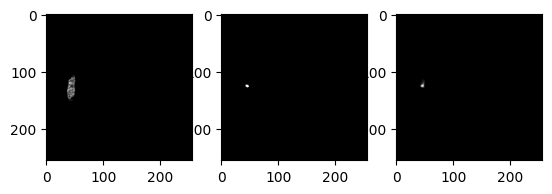

294.0
1/1 [==============================] - 0s 20ms/step


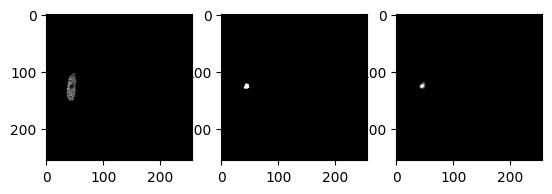

343.0
1/1 [==============================] - 0s 19ms/step


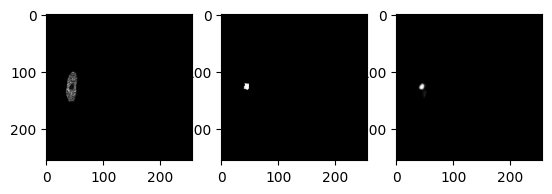

349.0
1/1 [==============================] - 0s 19ms/step


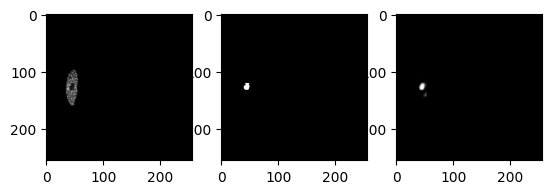

244.0
1/1 [==============================] - 0s 17ms/step


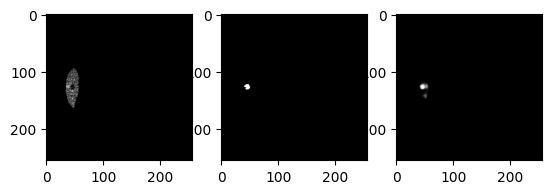

96.0
1/1 [==============================] - 0s 18ms/step


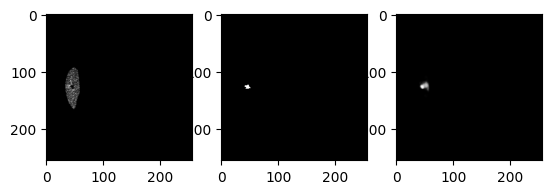

5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
64.0
1/1 [==============================] - 0s 18ms/step


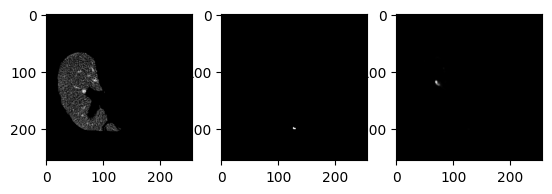

0.0
0.0
0.0
0.0
2.0
30.0
146.0
1/1 [==============================] - 0s 19ms/step


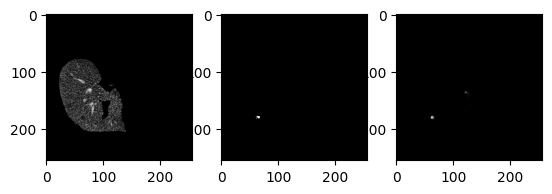

253.0
1/1 [==============================] - 0s 17ms/step


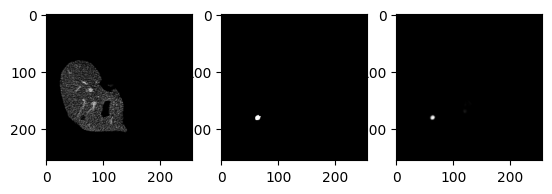

194.0
1/1 [==============================] - 0s 18ms/step


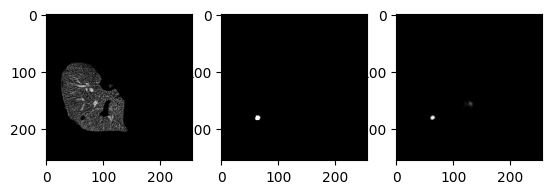

88.0
1/1 [==============================] - 0s 18ms/step


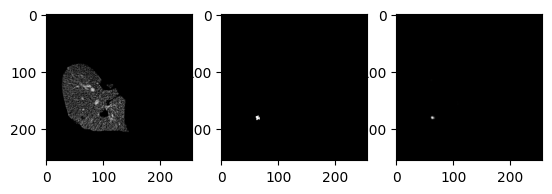

7.0
0.0
62.0
1/1 [==============================] - 0s 18ms/step


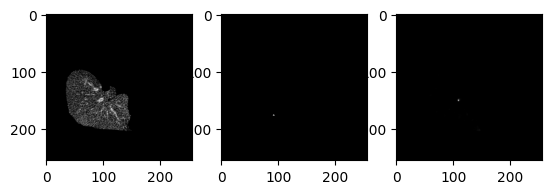

335.0
1/1 [==============================] - 0s 19ms/step


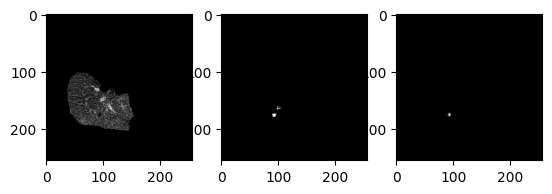

488.0
1/1 [==============================] - 0s 19ms/step


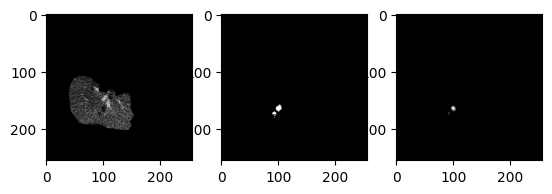

347.0
1/1 [==============================] - 0s 17ms/step


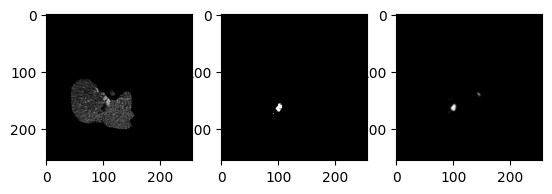

83.0
1/1 [==============================] - 0s 18ms/step


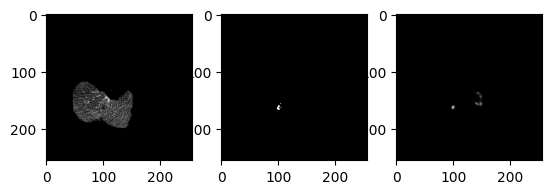

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
81.0
1/1 [==============================] - 0s 18ms/step


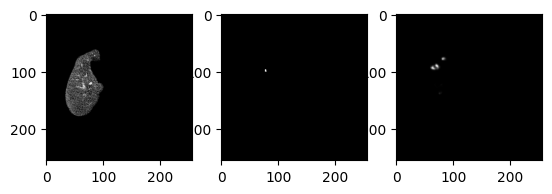

228.0
1/1 [==============================] - 0s 17ms/step


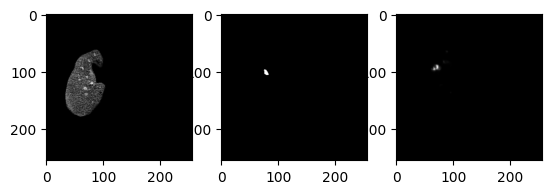

281.0
1/1 [==============================] - 0s 17ms/step


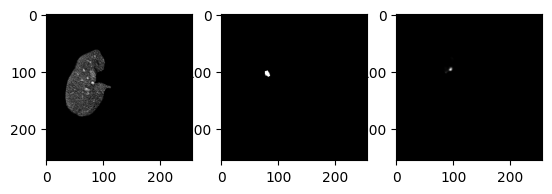

115.0
1/1 [==============================] - 0s 18ms/step


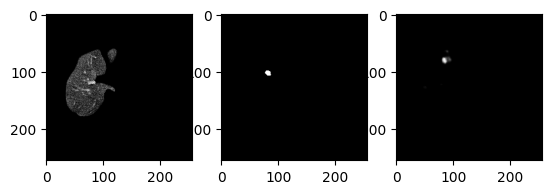

0.0
0.0
0.0
20.0
0.0
0.0
0.0
0.0
2.0
14.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
19.0
157.0
1/1 [==============================] - 0s 18ms/step


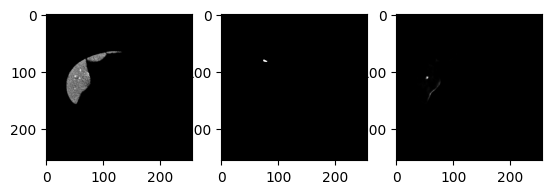

405.0
1/1 [==============================] - 0s 18ms/step


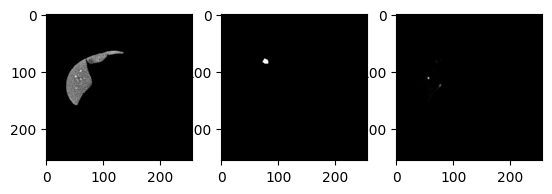

492.0
1/1 [==============================] - 0s 19ms/step


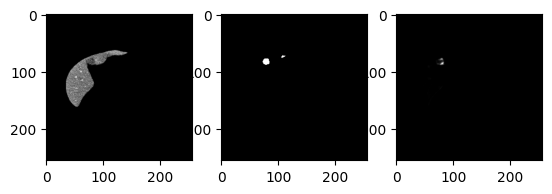

541.0
1/1 [==============================] - 0s 19ms/step


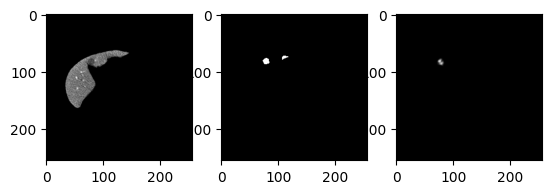

553.0
1/1 [==============================] - 0s 17ms/step


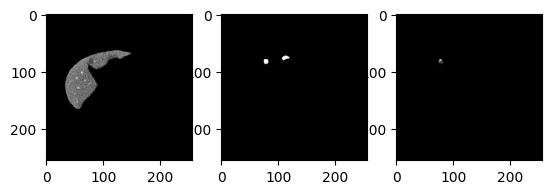

984.0
1/1 [==============================] - 0s 20ms/step


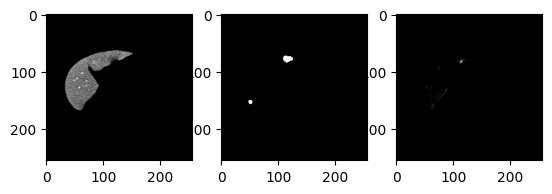

1259.0
1/1 [==============================] - 0s 18ms/step


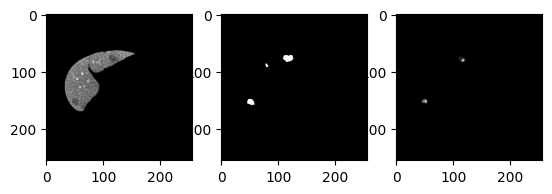

1414.0
1/1 [==============================] - 0s 19ms/step


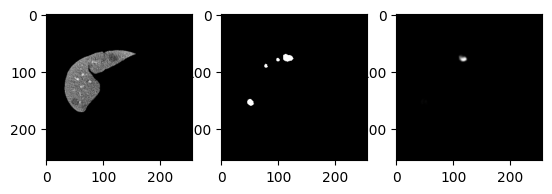

1643.0
1/1 [==============================] - 0s 19ms/step


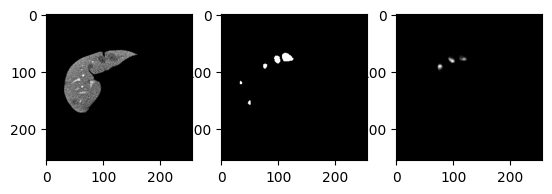

1401.0
1/1 [==============================] - 0s 20ms/step


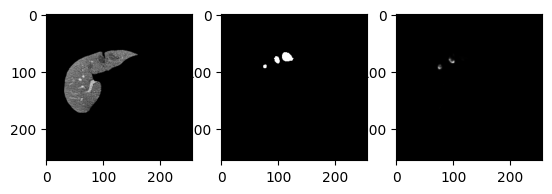

1452.0
1/1 [==============================] - 0s 19ms/step


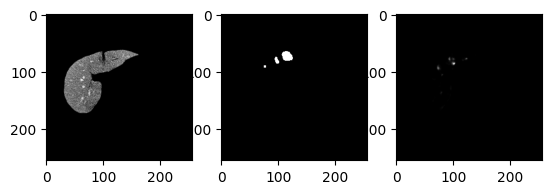

1964.0
1/1 [==============================] - 0s 19ms/step


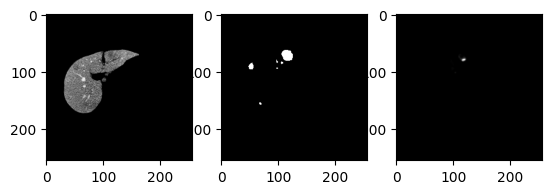

2291.0
1/1 [==============================] - 0s 18ms/step


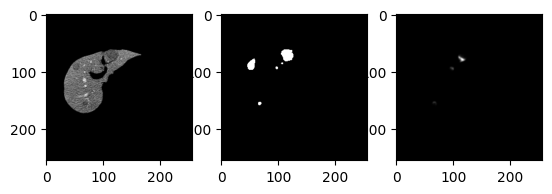

2259.0
1/1 [==============================] - 0s 18ms/step


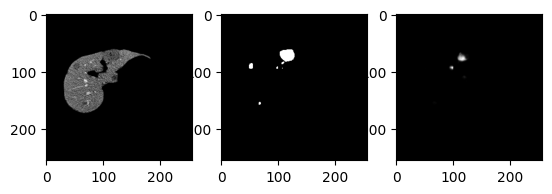

2254.0
1/1 [==============================] - 0s 17ms/step


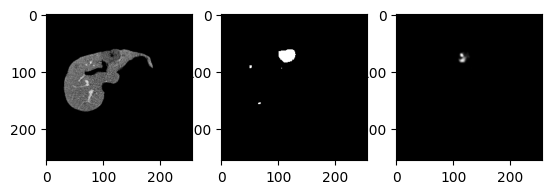

2227.0
1/1 [==============================] - 0s 18ms/step


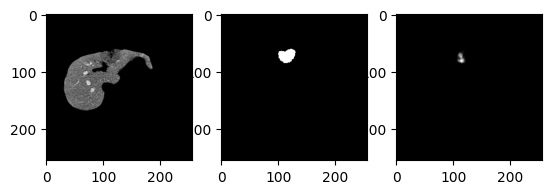

2123.0
1/1 [==============================] - 0s 19ms/step


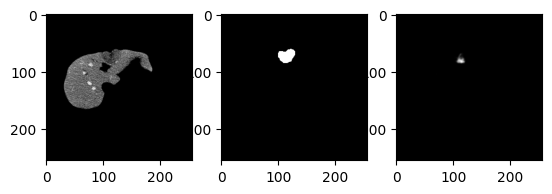

2099.0
1/1 [==============================] - 0s 18ms/step


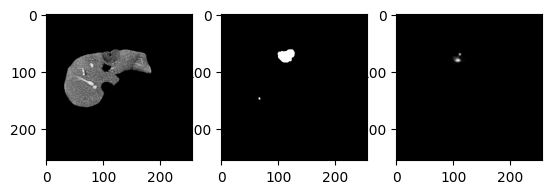

1848.0
1/1 [==============================] - 0s 20ms/step


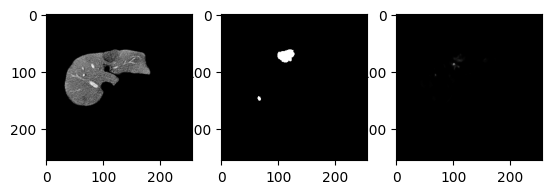

1176.0
1/1 [==============================] - 0s 21ms/step


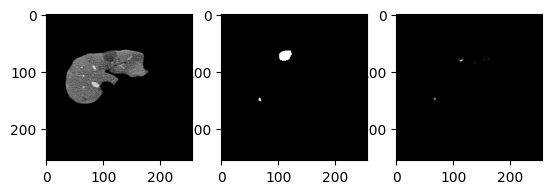

946.0
1/1 [==============================] - 0s 19ms/step


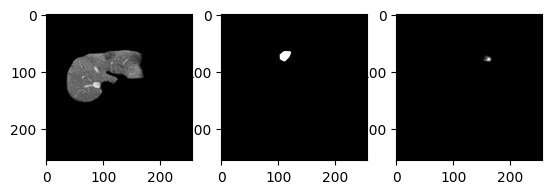

452.0
1/1 [==============================] - 0s 24ms/step


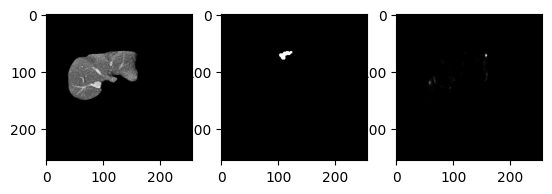

210.0
1/1 [==============================] - 0s 20ms/step


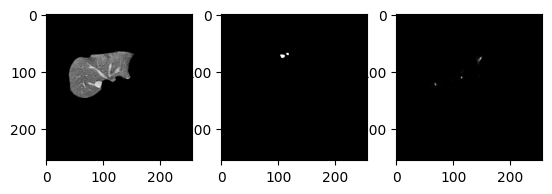

129.0
1/1 [==============================] - 0s 18ms/step


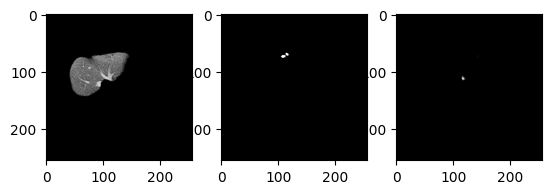

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
104.0
1/1 [==============================] - 0s 19ms/step


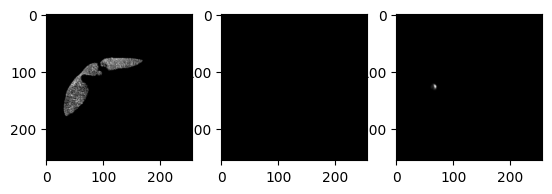

270.0
1/1 [==============================] - 0s 22ms/step


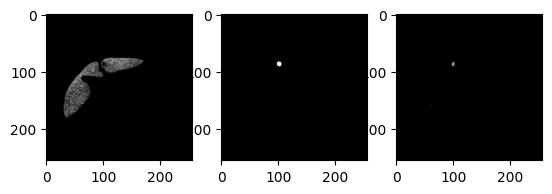

336.0
1/1 [==============================] - 0s 20ms/step


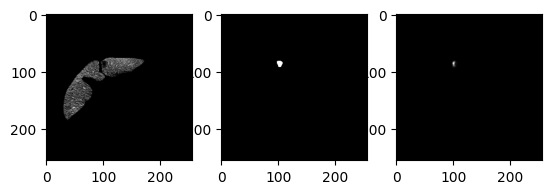

220.0
1/1 [==============================] - 0s 19ms/step


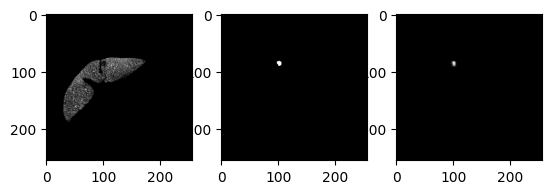

347.0
1/1 [==============================] - 0s 21ms/step


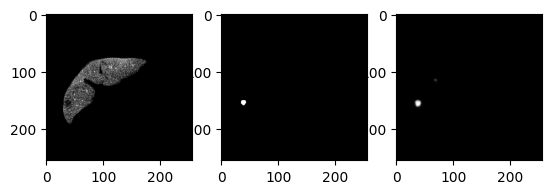

830.0
1/1 [==============================] - 0s 18ms/step


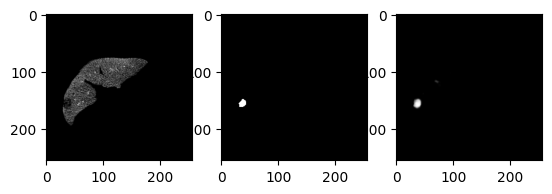

1036.0
1/1 [==============================] - 0s 18ms/step


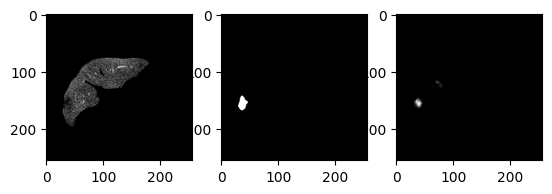

1131.0
1/1 [==============================] - 0s 19ms/step


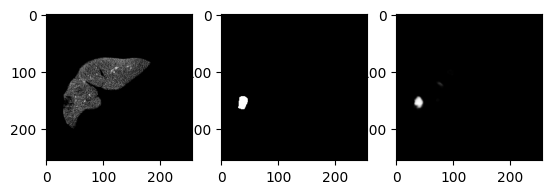

1488.0
1/1 [==============================] - 0s 18ms/step


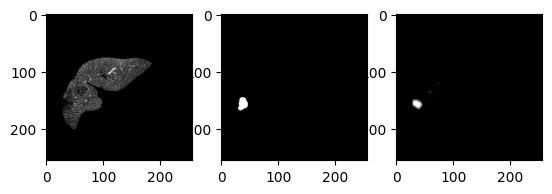

1198.0
1/1 [==============================] - 0s 18ms/step


KeyboardInterrupt: 

In [11]:
for sample in valid_dataset.take(1000):
    print(np.sum(sample[1]))
    if np.sum(sample[1]) > 50:
        presd = model.predict(sample[0])
        plt.subplot(1,3,1)
        plt.imshow(sample[0][0,:,:,0],cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(sample[1][0,:,:,0],cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(presd[0,:,:,0],cmap='gray')
        plt.show()
    